<a href="https://colab.research.google.com/github/hansal-trivedi/DeepLearning/blob/Hansal/Copy_of_CIFAR_10_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from sklearn.metrics import accuracy_score

In [2]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2021-02-13 13:44:27--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  52.4MB/s    in 3.4s    

2021-02-13 13:44:30 (47.7 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [3]:
!mkdir ./cifar_10/
!tar -xf cifar-10-python.tar.gz -C ./cifar_10/
!rm -rf cifar-10-python.tar.gz

In [4]:
!ls -l ./cifar_10/cifar-10-batches-py/

total 181876
-rw-r--r-- 1 2156 1103      158 Mar 31  2009 batches.meta
-rw-r--r-- 1 2156 1103 31035704 Mar 31  2009 data_batch_1
-rw-r--r-- 1 2156 1103 31035320 Mar 31  2009 data_batch_2
-rw-r--r-- 1 2156 1103 31035999 Mar 31  2009 data_batch_3
-rw-r--r-- 1 2156 1103 31035696 Mar 31  2009 data_batch_4
-rw-r--r-- 1 2156 1103 31035623 Mar 31  2009 data_batch_5
-rw-r--r-- 1 2156 1103       88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103 31035526 Mar 31  2009 test_batch


In [5]:
workdir = os.curdir
datadir = os.path.join(workdir,'cifar_10','cifar-10-batches-py')
train_files = [os.path.join(datadir,f'data_batch_{i}') for i in range(1,6)]
test_file = 'test_batch'

In [6]:
# unpickle the data file containing the image
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [7]:
data_dict = unpickle(train_files[0])
data_dict.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [8]:
# read all files into a dataset
data = np.empty(data_dict[b'data'].shape)
labels = list()
for fl in train_files:
  print(f"Loading File {fl}")
  df = unpickle(fl)
  print(df[b'batch_label'])
  print(f"Geting Data")
  if df[b'batch_label'] == b'training batch 1 of 5':
    data = df[b'data']
  else:
    data = np.concatenate([data,df[b'data']])
  print("Geting labels")
  labels = labels + df[b'labels']
  print(f"Shape of Data is {data.shape}")
  print("="*50)

Loading File ./cifar_10/cifar-10-batches-py/data_batch_1
b'training batch 1 of 5'
Geting Data
Geting labels
Shape of Data is (10000, 3072)
Loading File ./cifar_10/cifar-10-batches-py/data_batch_2
b'training batch 2 of 5'
Geting Data
Geting labels
Shape of Data is (20000, 3072)
Loading File ./cifar_10/cifar-10-batches-py/data_batch_3
b'training batch 3 of 5'
Geting Data
Geting labels
Shape of Data is (30000, 3072)
Loading File ./cifar_10/cifar-10-batches-py/data_batch_4
b'training batch 4 of 5'
Geting Data
Geting labels
Shape of Data is (40000, 3072)
Loading File ./cifar_10/cifar-10-batches-py/data_batch_5
b'training batch 5 of 5'
Geting Data
Geting labels
Shape of Data is (50000, 3072)


In [9]:
# Reading Metadata
label_meta = unpickle(os.path.join(datadir,'batches.meta'))[b'label_names']
label_meta_mapping = {i:label_meta[i].decode('utf-8') for i in range(len(label_meta))}
label_meta_mapping

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [10]:
labels = np.array(labels)
for i in range(0,10):
  lb_count = np.sum((labels == i)*1)
  print(f"{label_meta_mapping[i]}: {lb_count}")

airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


In [11]:
data_rgb = np.reshape(data, (data.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)

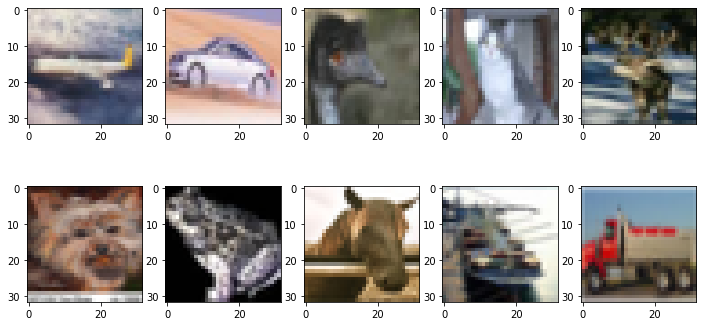

In [12]:
rnd_idx = np.random.randint(1,5000)
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12,6))
for i in range(10):
  samp = data_rgb[labels == i][rnd_idx,:,:,:]
  ax[int(i/5)][i%5].imshow(samp)

In [13]:
def prep_pixels(data):
  data_norm = data.astype('float32')

  data_norm = data_norm / 255.0

  return data_norm

In [14]:
data_rgb_norm = prep_pixels(data_rgb)

In [15]:
labels_b = tf.keras.utils.to_categorical(labels)

In [16]:
train_X, val_X, train_y, val_y = train_test_split(data_rgb_norm, labels_b, test_size=0.3)
#test_X, val_X, test_y, val_y = train_test_split(test_X, test_y, test_size=0.7)
print(f"Training Data Size : {train_X.shape[0]}")
print(f"Validation Data Size : {val_X.shape[0]}")
#print(f"Testing Data Size : {test_X.shape[0]}")

Training Data Size : 35000
Validation Data Size : 15000


In [ ]:
model = models.Sequential()
model.add(layers.Input(shape=train_X.shape[1:], batch_size=32))
model.add(layers.Dense(3072, activation='elu'))
model.add(layers.Dense(768, activation='elu'))
model.add(layers.Dense(196, activation='elu'))
model.add(layers.Dense(64, activation='elu'))
model.add(layers.Dense(10, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (32, 3072)                9440256   
_________________________________________________________________
dense_48 (Dense)             (32, 768)                 2360064   
_________________________________________________________________
dense_49 (Dense)             (32, 196)                 150724    
_________________________________________________________________
dense_50 (Dense)             (32, 64)                  12608     
_________________________________________________________________
dense_51 (Dense)             (32, 10)                  650       
Total params: 11,964,302
Trainable params: 11,964,302
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x=train_X, y=train_y, batch_size=32, epochs=10, validation_data=(val_X, val_y), workers=-1,use_multiprocessing=True)

Epoch 1/10
1250/1250 [==============================] - 6s 4ms/step - loss: 2.4595 - accuracy: 0.2263 - val_loss: 1.7882 - val_accuracy: 0.3438
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.8031 - accuracy: 0.3406 - val_loss: 1.7150 - val_accuracy: 0.3763
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.7085 - accuracy: 0.3820 - val_loss: 1.6243 - val_accuracy: 0.4130
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6413 - accuracy: 0.4063 - val_loss: 1.5587 - val_accuracy: 0.4352
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.5763 - accuracy: 0.4307 - val_loss: 1.5330 - val_accuracy: 0.4495
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.5210 - accuracy: 0.4560 - val_loss: 1.5172 - val_accuracy: 0.4463
Epoch 7/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.5043 - accuracy: 0.4613 - val_loss: 1.4881 - val_accuracy:

In [ ]:
def top_5_error_rate(predict_proba, y_true):
  result = 0
  for i in range(len(y_true)):
    row = predict_proba[i,:]
    top_5 = sorted(range(len(row)), key = lambda x: row[x], reverse=True)[:5]
    if y_true[i] in top_5:
      result = result + 1
  
  return result/len(y_true)

In [ ]:
proba_train_X = model.predict(test_X)
print(f'Accuracy Score : {model.evaluate(test_X, test_y)}')
print(top_5_error_rate(proba_train_X, test_y))

94/94 [==============================] - 0s 2ms/step - loss: 1.4332 - accuracy: 0.5017
Accuracy Score : [1.4332008361816406, 0.5016622543334961]
0.9163333333333333


In [ ]:
test_batch = unpickle(os.path.join(datadir,'test_batch'))
test_data = test_batch[b'data']
test_labels = test_batch[b'labels']

In [ ]:
test_data = np.reshape(test_data, (test_data.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)

'horse'

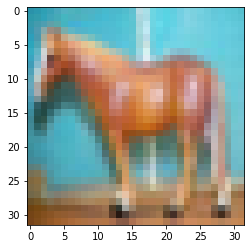

In [ ]:
idx = np.random.randint(200)
plt.imshow(test_data[idx])
label_meta_mapping[test_labels[idx]]

In [ ]:
proba_train_X = model.predict(np.reshape(test_data, (test_data.shape[0], 3072))/255)
print(f'Accuracy Score : {model.evaluate(np.reshape(test_data, (test_data.shape[0], 3072))/255, np.array(test_labels))}')
print(top_5_error_rate(proba_train_X, test_labels))

313/313 [==============================] - 1s 2ms/step - loss: 1.4188 - accuracy: 0.4946
Accuracy Score : [1.4188294410705566, 0.49460864067077637]
0.9177


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization


In [22]:
def define_model(opt = 'adam',loss = 'categorical_crossentropy'):
  model = Sequential()
  model.add(Conv2D(32,(3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32,32,3)))
  model.add(Conv2D(32,(3,3), activation='relu',kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.2))
  model.add(Conv2D(64,(3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64,(3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.2))
  model.add(Conv2D(128,(3,3), activation='relu',kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128,(3,3), activation='relu',kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer=opt, loss=loss, metrics = ['accuracy'])
  print(model.summary())
  return model

In [23]:
model = define_model()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)         

In [24]:
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(val_X,val_y), verbose=1)
_,acc= model.evaluate(val_X,val_y, verbose=0)
print('> %.3f' % (acc * 100.0))

Epoch 1/50
547/547 [==============================] - 12s 9ms/step - loss: 2.0474 - accuracy: 0.2669 - val_loss: 1.3857 - val_accuracy: 0.4977
Epoch 2/50
547/547 [==============================] - 4s 8ms/step - loss: 1.3431 - accuracy: 0.5178 - val_loss: 1.1118 - val_accuracy: 0.6019
Epoch 3/50
547/547 [==============================] - 4s 8ms/step - loss: 1.0941 - accuracy: 0.6146 - val_loss: 0.9962 - val_accuracy: 0.6495
Epoch 4/50
547/547 [==============================] - 4s 8ms/step - loss: 0.9394 - accuracy: 0.6700 - val_loss: 0.8882 - val_accuracy: 0.6852
Epoch 5/50
547/547 [==============================] - 4s 8ms/step - loss: 0.8117 - accuracy: 0.7116 - val_loss: 0.7926 - val_accuracy: 0.7245
Epoch 6/50
547/547 [==============================] - 4s 8ms/step - loss: 0.7319 - accuracy: 0.7417 - val_loss: 0.7828 - val_accuracy: 0.7290
Epoch 7/50
547/547 [==============================] - 4s 8ms/step - loss: 0.6544 - accuracy: 0.7670 - val_loss: 0.7288 - val_accuracy: 0.7481
Epoch